In [ ]:
# Installation (tu peux enlever apres avoir run)
%conda install -c conda-forge py-xgboost

In [25]:
import xgboost as xgb
import wandb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ift6758.data import load_cached_season_dataframe, load_cached_seasons_dataframe, new_variables, goal_rate_by_percentile
from ift6758.data.graphs import plot_goal_curve
from sklearn.calibration import CalibrationDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, roc_curve, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df_training = load_cached_seasons_dataframe(2016,2019) 
df_test = load_cached_season_dataframe(2020) # on y touche pas jusqu'à la fin
df = new_variables(df_training)
df_training # petit apperçu

,timeInPeriod,gameSeconds,period,eventId,teamShot,typeEvent,x,y,shooter,goalie,...,lastEventY,timeSinceLastEvent,distanceSinceLastEvent,goalStrenght,friendlySkaters,opposingSkaters,timeInPowerPlay,gameId,season,gameType
0,01:11,71,1,8,TOR,shot-on-goal,-77.0,5.0,Mitch Marner,Craig Anderson,...,11.0,1.0,17.088007,EV,5,5,0,2016020001,2016,2
1,02:53,173,1,11,OTT,shot-on-goal,86.0,13.0,Chris Kelly,Frederik Andersen,...,-5.0,5.0,36.715120,EV,5,5,0,2016020001,2016,2
2,04:01,241,1,15,OTT,shot-on-goal,23.0,-38.0,Cody Ceci,Frederik Andersen,...,0.0,18.0,102.318131,EV,5,5,0,2016020001,2016,2
3,04:46,286,1,16,OTT,shot-on-goal,33.0,-15.0,Erik Karlsson,Frederik Andersen,...,-2.0,19.0,45.880279,EV,5,5,0,2016020001,2016,2
4,06:46,406,1,24,TOR,shot-on-goal,-34.0,28.0,Martin Marincin,Craig Anderson,...,34.0,16.0,81.221918,EV,5,5,0,2016020001,2016,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327337,16:01,3361,3,706,TBL,shot-on-goal,-59.0,-24.0,Anthony Cirelli,Anton Khudobin,...,-26.0,3.0,123.016259,SH,4,5,0,2019030416,2019,3
327338,17:20,3440,3,709,TBL,shot-on-goal,-81.0,3.0,Blake Coleman,Anton Khudobin,...,6.0,2.0,3.162278,SH,4,5,0,2019030416,2019,3
327339,18:50,3530,3,713,DAL,shot-on-goal,34.0,-6.0,John Klingberg,Andrei Vasilevskiy,...,-16.0,8.0,58.855756,EV,6,5,0,2019030416,2019,3
327340,19:27,3567,3,719,DAL,shot-on-goal,31.0,10.0,John Klingberg,Andrei Vasilevskiy,...,-22.0,5.0,49.678969,EV,6,5,0,2019030416,2019,3


## Séparation des ensembles d'entraînement et de validation

In [6]:
feature_sets = {
    "Distance": ["shotDistance"],
    "Angle": ["shotAngle"],
}

two_features = sorted({col for cols in feature_sets.values() for col in cols})

X_distance_angle = df[two_features].copy()
y_distance_angle = df["isGoal"].astype(int)

mask = X_distance_angle.notna().all(axis=1)
X_distance_angle = X_distance_angle.loc[mask]
y_distance_angle = y_distance_angle.loc[mask]

X_train_distance_angle, X_val_distance_angle, y_train_distance_angle, y_val_distance_angle = train_test_split(X_distance_angle, y_distance_angle, test_size=0.2, random_state=42)

# Modèle XGBoost avec la distance et l'angle

In [10]:
# Initialisation de WandB
# On spécifie le projet, mais on ne log pas dans le registre d'artefacts (model registry)
run = wandb.init(
    project="projet-hockey-ai", 
    name="xgboost-baseline-dist-angle",
    tags=["baseline", "xgboost"],
    save_code=True
)

XGBoost_distance_angle = xgb.XGBClassifier(eval_metric='logloss', random_state=42)

XGBoost_distance_angle.fit(X_train_distance_angle, y_train_distance_angle)

# Prédictions
y_pred_distance_angle = XGBoost_distance_angle.predict(X_val_distance_angle)
y_proba_distance_angle = XGBoost_distance_angle.predict_proba(X_val_distance_angle)

# 6. Calcul des métriques
acc_distance_angle = accuracy_score(y_val_distance_angle, y_pred_distance_angle)
auc_distance_angle = roc_auc_score(y_val_distance_angle, y_proba_distance_angle[:, 1])
ll_distance_angle = log_loss(y_val_distance_angle, y_proba_distance_angle[:, 1])

print(f"Accuracy: {acc_distance_angle}")
print(f"AUC: {auc_distance_angle}")
print(f"Log Loss: {ll_distance_angle}")

# Logging automatique des courbes dans WandB
# WandB crée automatiquement la courbe ROC, la matrice de confusion et la courbe de précision-rappel
wandb.sklearn.plot_classifier(
    XGBoost_distance_angle, X_train_distance_angle, X_val_distance_angle, y_train_distance_angle, y_val_distance_angle,
    y_pred_distance_angle, y_proba_distance_angle, 
    labels=['Non-Goal', 'Goal'], 
    model_name='XGBoost Baseline', 
    feature_names=['distance', 'angle']
)

wandb.log({"accuracy": acc_distance_angle, "auc": auc_distance_angle, "log_loss": ll_distance_angle})

run.finish()

Accuracy: 0.9059191934621553
AUC: 0.7153947569488606
Log Loss: 0.28689577826097273


wandb: 
wandb: Plotting XGBoost Baseline.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


accuracy,▁
auc,▁
log_loss,▁
accuracy,0.90592
auc,0.71539
log_loss,0.2869


### Matrice de confusion

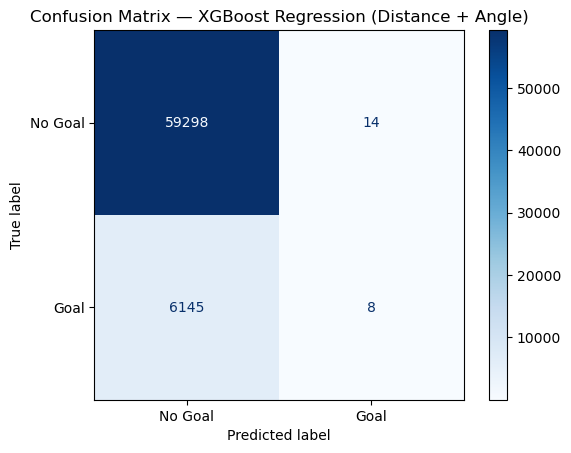

In [16]:
disp = ConfusionMatrixDisplay.from_predictions(
    y_val_distance_angle, y_pred_distance_angle,
    display_labels=["No Goal", "Goal"],   
    values_format="d",
    cmap="Blues"
)
plt.title("Confusion Matrix — XGBoost Regression (Distance + Angle)")
plt.grid(False)
plt.show()

### Courbes ROC-AUC 

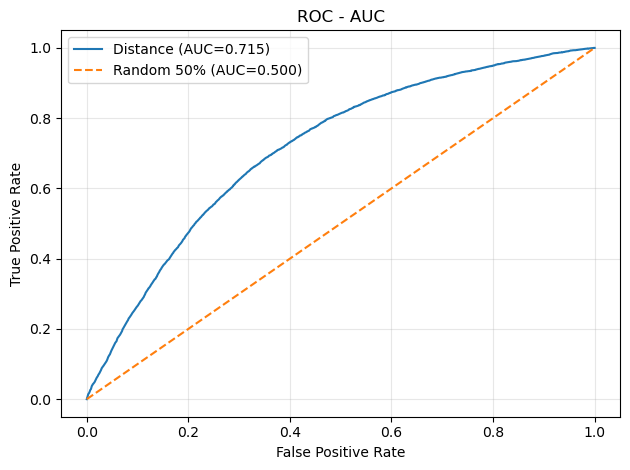

In [17]:
# Proba
pos_idx_distance_angle  = np.where(XGBoost_distance_angle.classes_  == 1)[0][0]
proba_distance_angle  = XGBoost_distance_angle.predict_proba(X_val_distance_angle)[:,  pos_idx_distance_angle]

# ROC-AUC
fpr_distance_angle,  tpr_distance_angle,  _ = roc_curve(y_val_distance_angle, proba_distance_angle)
auc_distance_angle = roc_auc_score(y_val_distance_angle, proba_distance_angle)

plt.plot(fpr_distance_angle,  tpr_distance_angle,  label=f"Distance (AUC={auc_distance_angle:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--", label="Random 50% (AUC=0.500)")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC - AUC")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Taux de buts en fonction du centile de la probabilité de tir

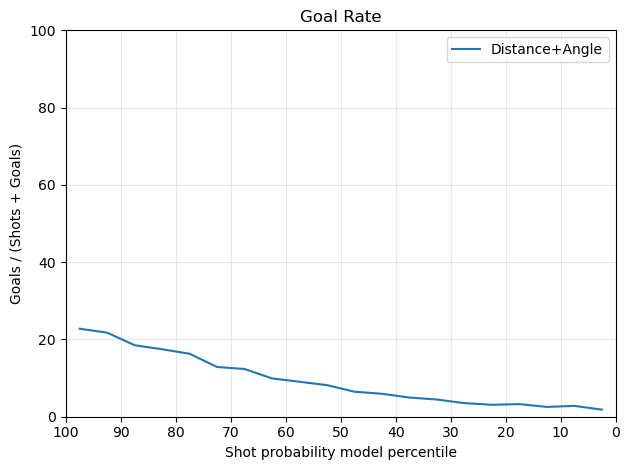

In [20]:
x_distance_angle, goal_rate_distance_angle = goal_rate_by_percentile(y_val_distance_angle, proba_distance_angle, step=5)
goal_rate_percent_distance_angle = 100.0 * goal_rate_distance_angle

plt.plot(x_distance_angle,  goal_rate_percent_distance_angle,  label="Distance+Angle")

plt.title("Goal Rate")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Goals / (Shots + Goals)")
plt.grid(alpha=0.3)

plt.xlim(100, 0)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)

plt.legend()
plt.tight_layout()
plt.show()

### Proportion cumulée de but en fonction du centile de la probabilité de tir

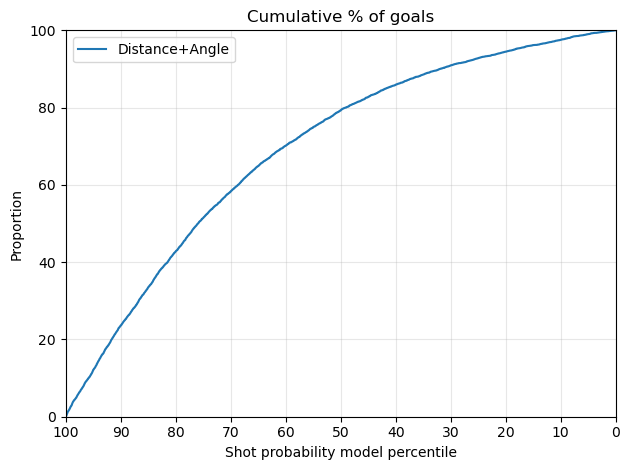

In [23]:
plot_goal_curve(y_val_distance_angle, proba_distance_angle, "Distance+Angle")

plt.title("Cumulative % of goals")
plt.xlabel("Shot probability model percentile")
plt.ylabel("Proportion")
plt.grid(alpha=0.3)

plt.xlim(100, 0)
plt.xticks(np.arange(0, 101, 10))
plt.ylim(0, 100)

plt.legend()
plt.tight_layout()
plt.show()

### Diagramme de fiabilité

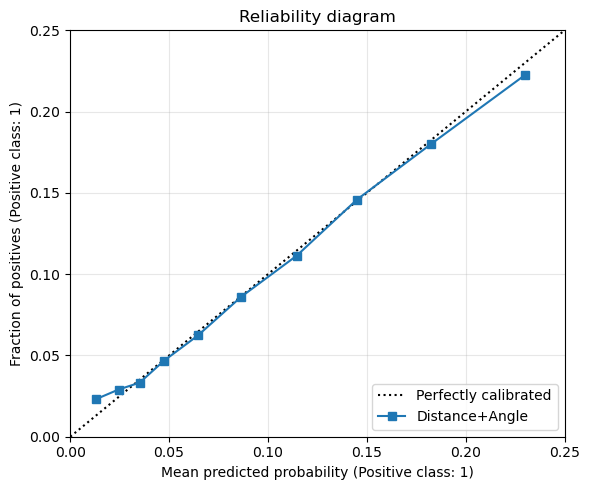

In [27]:
fig, ax = plt.subplots(figsize=(6, 5))

CalibrationDisplay.from_predictions(
    y_true=y_val_distance_angle,
    y_prob=proba_distance_angle,
    n_bins=10,
    strategy="quantile",
    name="Distance+Angle",
    ax=ax
)

ax.set_xlim(0, 0.25)
ax.set_ylim(0, 0.25)
ax.grid(alpha=0.3)
ax.set_title("Reliability diagram")
plt.tight_layout()
plt.show()